In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil 
from gradcam import GradCAM
import cv2
import argparse
#from classification_models.keras import Classifiers
from classification_models.tfkeras import Classifiers


import tensorflow
tf.__version__

'2.1.0'

In [12]:

# Directory with covid xray pictures
covid_dir = os.path.join(r"new_cxr_dataset/COVID-19")

# Directory with normal xray pictures
normal_dir = os.path.join(r"new_cxr_dataset/NORMAL")

# Directory with pneuomina xray pictures
viral_pneumonia_dir = os.path.join(r"new_cxr_dataset/Viral Pneumonia")

covid_names = os.listdir(covid_dir)
print(covid_names[:10])

normal_names = os.listdir(normal_dir)
print(normal_names[:10])

viral_pneumonia_names = os.listdir(viral_pneumonia_dir)
print(viral_pneumonia_names[:10])

print('total covid xray pictures:', len(os.listdir(covid_dir)))
print('total normal xray pictures:', len(os.listdir(normal_dir)))
print('total viral pneuomina xray pictures:', len(os.listdir(viral_pneumonia_dir)))


['smooth_COVID-19(198).png', 'bright_COVID-19 (114).png', 'bright_COVID-19(167).png', 'rot_COVID-19(166).png', 'bright_COVID-19(219).png', 'smooth_COVID-19 (82).png', 'arot_COVID-19(202).png', 'gblur_COVID-19 (56).png', 'gblur_COVID-19 (43).png', 'con_COVID-19 (104).png']
['NORMAL (328).png', 'NORMAL (1292).png', 'NORMAL (697).png', 'NORMAL (1013).png', 'NORMAL (343).png', 'NORMAL (446).png', 'NORMAL (211).png', 'NORMAL (1214).png', 'NORMAL (353).png', 'NORMAL (541).png']
['Viral Pneumonia (36).png', 'Viral Pneumonia (729).png', 'Viral Pneumonia (380).png', 'Viral Pneumonia (902).png', 'Viral Pneumonia (833).png', 'Viral Pneumonia (1236).png', 'Viral Pneumonia (188).png', 'Viral Pneumonia (326).png', 'Viral Pneumonia (867).png', 'Viral Pneumonia (410).png']
total covid xray pictures: 1160
total normal xray pictures: 1332
total viral pneuomina xray pictures: 1329


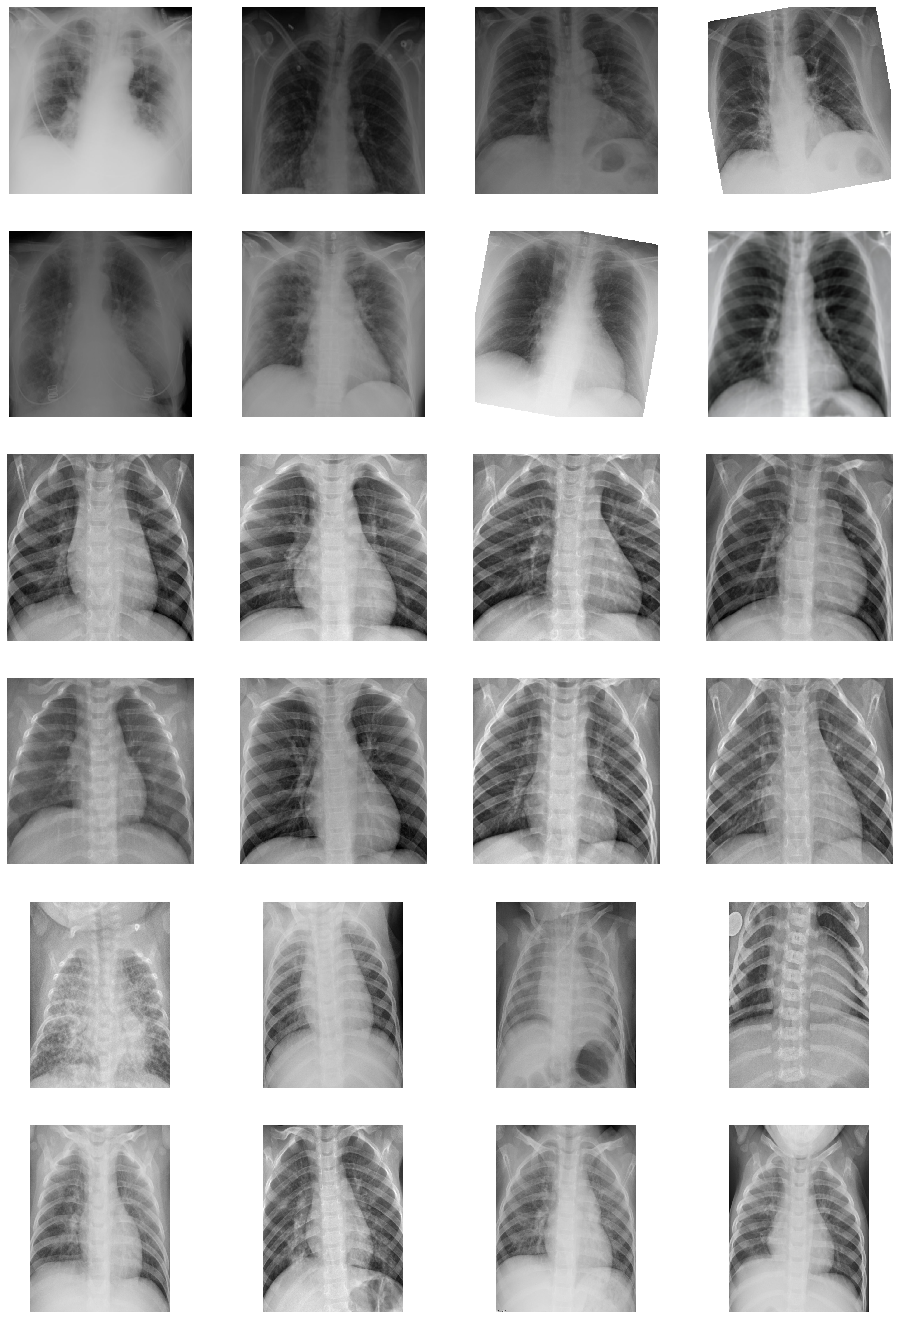

In [13]:
"""
DISPLAYING SOME PICTURES
"""
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(covid_dir, fname) 
                for fname in covid_names[pic_index-8:pic_index]]
next_normal_pix = [os.path.join(normal_dir, fname) 
                for fname in normal_names[pic_index-8:pic_index]]
next_viral_pneumonia_pix = [os.path.join(viral_pneumonia_dir, fname) 
                for fname in viral_pneumonia_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_covid_pix+next_normal_pix+next_viral_pneumonia_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [14]:
"""
HYPER-PARAMETERS
"""

img_height = 224
img_width = 224
batch_size = 16
nb_epochs = 50
base_learning_rate = 0.0001


In [25]:
"""
DIVIDING THE IMAGES INTO TRAIN AND TEST
"""
import glob
covid = glob.glob(covid_dir+"/*.*")
normal = glob.glob(normal_dir+"/*.*")
viral_pneumonia = glob.glob(viral_pneumonia_dir+"/*.*")

data = []
labels = []

for i in covid:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in normal:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in viral_pneumonia:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(2)


data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                shuffle=True,
                                                random_state=40)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:

"""
CONSTRUCTING OUR GENERATOR FOR IMAGE AUGMENTATION
"""
datagen = ImageDataGenerator(rescale=1./255,
        horizontal_flip=True) 

"""
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

validation_generator = datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_height, img_width),
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 
"""

"\ntrain_generator = datagen.flow_from_directory(\n    train_data_dir,\n    target_size=(img_height, img_width),\n    shuffle=True,\n    batch_size=batch_size,\n    class_mode='categorical',\n    subset='training') \n\nvalidation_generator = datagen.flow_from_directory(\n    train_data_dir, \n    target_size=(img_height, img_width),\n    shuffle=True,\n    batch_size=batch_size,\n    class_mode='categorical',\n    subset='validation') \n"

In [17]:
"""
RESNET-18 MODEL
"""
def resnet():
    
    

# for tensorflow.keras
    from classification_models.tfkeras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
    

    
    
    
    #base_model.trainable = False
    
    #for i in range(21,len(base_model.layers)):
        #base_model.layers[i].trainable = False

    base_model.summary()
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      #tf.keras.layers.Dense(128,activation="relu"),
      #tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64,activation="relu"),
      #tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(3,activation="softmax")
    ])
    return model

In [18]:
"""
VGG-16 MODEL
""" 
def vgg16():
    
    base_model = VGG16(input_shape=(img_height, img_width, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    
    
    #base_model.trainable = False
    
    #for i in range(len(base_model.layers)-1):
        #base_model.layers[i].trainable = False
    
    base_model.summary()
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      #tf.keras.layers.Dense(1024,activation="relu"),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64,activation="relu"),
      tf.keras.layers.Dense(3,activation="softmax")
    ])

    return model


In [19]:

"""
BASE MODELS
"""
basemodels=[]
basemodels.append(VGG16(input_shape=(img_height, img_width, 3),
                                                   include_top=False,
                                                   weights=None))

In [20]:
"""
STACKING MODELS IN A LIST
"""
models = []
#models.append(resnet())
models.append(vgg16())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
"""
SAVING MODEL TO DIRECTORY :



model_dir = os.path.join(r"models")
if os.path.exists(model_dir):
    shutil.rmtree("models")
    #os.removedirs(r"models")
    os.makedirs(r"models")
else:
    os.makedirs(r"models")
"""

'\nSAVING MODEL TO DIRECTORY :\n\n\n\nmodel_dir = os.path.join(r"models")\nif os.path.exists(model_dir):\n    shutil.rmtree("models")\n    #os.removedirs(r"models")\n    os.makedirs(r"models")\nelse:\n    os.makedirs(r"models")\n'

In [22]:
"""
CALLBACK

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
"""

'\nCALLBACK\n\nclass myCallback(tf.keras.callbacks.Callback):\n  def on_epoch_end(self, epoch, logs={}):\n    if(logs.get(\'val_accuracy\')>0.93):\n      print("\nReached 93% accuracy so cancelling training!")\n      self.model.stop_training = True\n\ncallbacks = myCallback()\n'

In [23]:
imaget = "nejmoa2001191_f5-PA.jpeg"

  ...
    to  
  ['...']
Train for 191 steps, validate on 765 samples
Epoch 1/50
191/191 [==============================] - 16s 83ms/step - loss: 0.0563 - accuracy: 0.9813 - val_loss: 11.1151 - val_accuracy: 0.9056
Epoch 2/50
191/191 [==============================] - 15s 79ms/step - loss: 0.0464 - accuracy: 0.9836 - val_loss: 11.1984 - val_accuracy: 0.9282
Epoch 3/50
191/191 [==============================] - 15s 78ms/step - loss: 0.0509 - accuracy: 0.9823 - val_loss: 7.8060 - val_accuracy: 0.9322
Epoch 4/50
191/191 [==============================] - 15s 79ms/step - loss: 0.0255 - accuracy: 0.9902 - val_loss: 7.1006 - val_accuracy: 0.9322
Epoch 5/50
191/191 [==============================] - 15s 79ms/step - loss: 0.0263 - accuracy: 0.9902 - val_loss: 5.3575 - val_accuracy: 0.9468
Epoch 6/50
191/191 [==============================] - 15s 79ms/step - loss: 0.0787 - accuracy: 0.9774 - val_loss: 40.2219 - val_accuracy: 0.8125
Epoch 7/50
191/191 [==============================] - 15s 78ms/

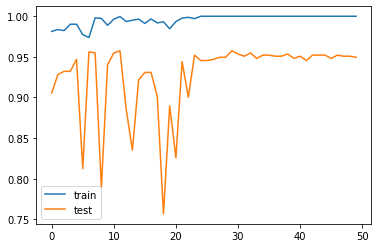

In [27]:

"""
MODEL COMPILING AND FITTING AND SAVING
"""
for i in range(len(models)):
    #Compiling 
    models[i].compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),#beta_1=0.9, beta_2=0.999),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    
    
    H = models[i].fit(
        datagen.flow(x_train,y_train, batch_size = batch_size),
        steps_per_epoch = len(x_train) // batch_size,
        validation_data = (x_test,y_test), 
        validation_steps = len(x_test) // batch_size,
        epochs = nb_epochs)
        
    
    filename = "models/model_" + str(i + 1) + ".h5"
    models[i].save(filename)
    print(">Saved %s" % filename)
       
    """
    EVALUATING MODEL
    """
    
    print("Evaluating network...")
    predIdxs = models[i].predict(x_test, batch_size= batch_size)
    
    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    predIdxs = np.argmax(predIdxs, axis=1)
    
    print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=["Covid","Normal","Pneuomonia"]))
    

    cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    
    # learning curves of model accuracy
    plt.plot(H.history['accuracy'], label='train')
    plt.plot(H.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    


   
  

In [29]:
 """
    GRADCAM
 """
    
print("Loading model...")
lmodel = tf.keras.models.load_model("models/model_1.h5")
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread(imaget)
resized = cv2.resize(orig, (224, 224))


image = load_img(imaget, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)


preds = lmodel.predict(image)
j = np.argmax(preds[0])


label1 = "{}: {:.2f}%".format(j, max(preds[0]) * 100)
print("[INFO] {}".format(label1))


# initialize gradient class activation map and build the heatmap
cam = GradCAM(lmodel, j)
heatmap = cam.compute_heatmap(image)

# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label1, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
    0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
#cv2.imshow("Output", output)
#cv2.waitKey(0)
cv2.imwrite("Output.jpg",output)

Loading model...
[INFO] 0: 100.00%


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_3_2:0", shape=(None, 224, 224, 3), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []